In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import csv
import unidecode
import math
import utm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_weighted_mean(data):
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if math.isnan(x) else x)
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if int(x) == 0 else x)
    data['MP'] = data['FE_VIA'] * data['DURACAO']
    return data

folder_data = "../data/"
arq17 = "dados17.csv"

data17 = pd.read_csv(folder_data + arq17, dtype={'ZONA_O': str, 'ZONA_D': str}, header=0,delimiter=";", low_memory=False) 
data17 = data17.dropna(subset=['CO_O_X'])

data17 = data17.drop(['ID_DOM', 'FE_DOM', 'VIA_BICI','TP_ESTBICI','F_FAM','FE_FAM','FAMILIA','NO_MORAF',
                      'CONDMORA','QT_BANHO','QT_EMPRE','QT_AUTO','QT_MICRO','QT_LAVALOU','QT_GEL1'], axis=1)

csv_file = folder_data + "regioes17.csv"
mydict = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    mydict = {rows[0]:rows[1] for rows in reader}

csv_file = folder_data + "zonas17.csv"
zonas_nomes = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    zonas_nomes = {rows[0]:rows[1] for rows in reader}
    
data17 = data17[data17['MUNI_O'] == 36]
data17 = data17[data17['MUNI_D'] == 36]

data17['NOME_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else mydict[x])
data17['NOME_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else mydict[x])

data17['ZONA_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])
data17['ZONA_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])

data17['NUM_TRANS'] = data17[['MODO1', 'MODO2','MODO3','MODO4']].count(axis=1)

data17 = calculate_weighted_mean(data17)

data17.head()

,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,F_DOM,DOM,CD_ENTRE,DATA,TIPO_DOM,AGUA,...,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,ID_ORDEM,NOME_O,NOME_D,NUM_TRANS,MP
0,1,36,333743,7394463,1,1,1,6092017,1,1,...,3.0,NaN,NaN,NaN,1.0,1,Se,Se,1,221.32647
1,1,36,333743,7394463,0,1,1,6092017,1,1,...,3.0,NaN,NaN,NaN,1.0,2,Se,Se,1,221.32647
2,1,36,333743,7394463,0,1,1,6092017,1,1,...,1.0,2.0,NaN,NaN,NaN,3,Se,Pinheiros,1,944.12435
3,1,36,333743,7394463,0,1,1,6092017,1,1,...,1.0,2.0,NaN,NaN,NaN,4,Pinheiros,Perdizes,2,1132.94922
4,1,36,333743,7394463,0,1,1,6092017,1,1,...,2.0,NaN,NaN,NaN,NaN,5,Perdizes,Se,1,755.29948


In [3]:
modos17 = {0:'outros',1:'metro',2:'trem',3:'metro',4:'onibus',5:'onibus',6:'onibus',7:'fretado', 8:'escolar',9:'carro-dirigindo', 10: 'carro-passageiro', 11:'taxi', 12:'taxi-nao-convencional', 13:'moto', 14:'moto-passageiro', 15:'bicicleta', 16:'pe', 17: 'outros'}
data17['MODOPRIN'] = data17['MODOPRIN'].replace(modos17)

data17['MODOPRIN'].head()

0                       pe
1                       pe
2                    metro
3                    metro
4    taxi-nao-convencional
Name: MODOPRIN, dtype: object

In [4]:
conj17 = data17[['MODOPRIN', 'FE_VIA']].groupby(['MODOPRIN']).sum().sort_values(by=['FE_VIA']).reset_index()
conj17.columns = ['MODOPRIN', 'FE_VIA']
conj17 = conj17.set_index('MODOPRIN')
conj17

,FE_VIA
MODOPRIN,
fretado,3.337329e+04
moto-passageiro,3.875655e+04
outros,5.402288e+04
taxi,8.274082e+04
bicicleta,2.045023e+05
taxi-nao-convencional,2.485057e+05
moto,4.288413e+05
trem,4.612448e+05
escolar,1.109075e+06


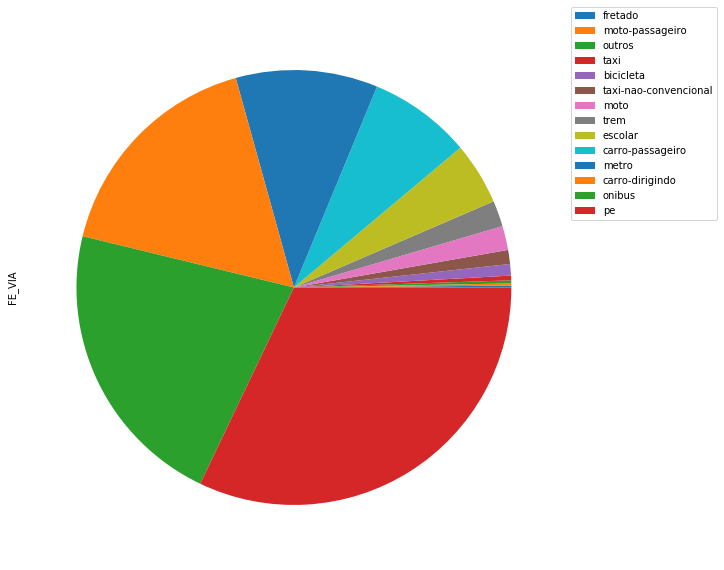

In [5]:
plt.figure(figsize=(26,10))
# plot chart
ax1 = plt.subplot(121, aspect='equal')

conj17.plot(kind='pie', y = 'FE_VIA', labels=None, ax=ax1,legend = True, fontsize=14)
plt.legend(labels=conj17.index, bbox_to_anchor=(1,1.025), loc="upper left")
# plot table
plt.show()

In [6]:
conj17

,FE_VIA
MODOPRIN,
fretado,3.337329e+04
moto-passageiro,3.875655e+04
outros,5.402288e+04
taxi,8.274082e+04
bicicleta,2.045023e+05
taxi-nao-convencional,2.485057e+05
moto,4.288413e+05
trem,4.612448e+05
escolar,1.109075e+06


4 milhões de carro 200  mil de bicicleta

In [7]:
modo_distri = data17[['MODOPRIN', 'NOME_O', 'FE_VIA']].groupby(['MODOPRIN','NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
modo_distri.columns = ['MODOPRIN', 'NOME_O', 'FE_VIA_BIKE']
modo_distri = modo_distri[modo_distri['MODOPRIN'] == 'bicicleta']

modo_distri = modo_distri.set_index('NOME_O')


modo_distri

distrito = data17[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distrito.columns = ['NOME_O', 'FE_VIA_TOTAL']
distrito = distrito.set_index('NOME_O')


modo_distri = modo_distri.join(distrito)

modo_distri = modo_distri.drop(['MODOPRIN'], axis=1)
modo_distri['PORCETAGEM'] = modo_distri['FE_VIA_BIKE'] / modo_distri['FE_VIA_TOTAL'] * 100
modo_distri.columns = ['Bicicleta', 'Total', 'Bicicleta (%)']
modo_distri = modo_distri.round(2)
modo_distri['Bicicleta'] = modo_distri['Bicicleta'].round(0)
modo_distri['Total'] = modo_distri['Total'].round(0)
modo_distri.sort_values(by=['Bicicleta (%)']).tail(10)


,Bicicleta,Total,Bicicleta (%)
NOME_O,,,
Itaim Bibi,11245.0,547034.0,2.06
Pinheiros,8215.0,366260.0,2.24
Pari,1711.0,72105.0,2.37
Socorro,3062.0,118084.0,2.59
Iguatemi,6567.0,211175.0,3.11
Vila Maria,7304.0,227562.0,3.21
Ipiranga,10386.0,318122.0,3.26
Jaguare,3293.0,98784.0,3.33
Jardim Helena,8629.0,204378.0,4.22


In [8]:

modo_distri.sort_values(by=['Bicicleta (%)']).head(20)

,Bicicleta,Total,Bicicleta (%)
NOME_O,,,
Cidade Ademar,67.0,410738.0,0.02
Capao Redondo,269.0,475712.0,0.06
Jabaquara,284.0,504911.0,0.06
Tucuruvi,272.0,208975.0,0.13
Brasilandia,485.0,376310.0,0.13
Campo Grande,472.0,260019.0,0.18
Cidade Tiradentes,660.0,360709.0,0.18
Itaquera,691.0,357788.0,0.19
Jardim Sao Luis,848.0,450746.0,0.19


In [9]:
conj17['POR'] = conj17['FE_VIA'] / conj17['FE_VIA'].sum() * 100
conj17

,FE_VIA,POR
MODOPRIN,,
fretado,3.337329e+04,0.139438
moto-passageiro,3.875655e+04,0.161930
outros,5.402288e+04,0.225715
taxi,8.274082e+04,0.345702
bicicleta,2.045023e+05,0.854437
taxi-nao-convencional,2.485057e+05,1.038289
moto,4.288413e+05,1.791755
trem,4.612448e+05,1.927141
escolar,1.109075e+06,4.633859


10 vezes mais ciagens de carro

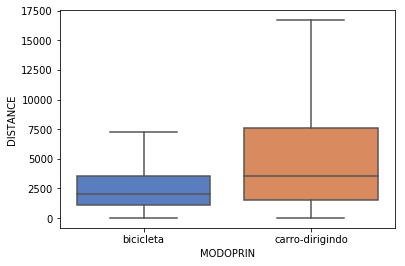

In [10]:
folder_data = "../data/"
arq17 = "dados17_distance.csv"

data17_distance = pd.read_csv(folder_data + arq17, dtype={'ZONA_O': str, 'ZONA_D': str}, header=0,delimiter=",", low_memory=False) 
data17_distance = data17_distance.dropna(subset=['CO_O_X'])

modos17 = {0:'outros',1:'metro',2:'trem',3:'metro',4:'onibus',5:'onibus',6:'onibus',7:'fretado', 8:'escolar',9:'carro-dirigindo', 10: 'carro-passageiro', 11:'taxi', 12:'taxi-nao-convencional', 13:'moto', 14:'moto-passageiro', 15:'bicicleta', 16:'pe', 17: 'outros'}
data17_distance['MODOPRIN'] = data17_distance['MODOPRIN'].replace(modos17)

bicicleta = data17_distance[data17_distance['MODOPRIN'] == 'bicicleta']

carro = data17_distance[data17_distance['MODOPRIN'] == 'carro-dirigindo']


total = bicicleta.append(carro)
total.head()

sns.boxplot(x="MODOPRIN", y="DISTANCE", data=total, palette="muted", showfliers = False)



Apesar das viagens de bicicletas serem menores que as de carro, metade das viagens de carro tem distâncias iguais ou menores que 75% viagens de bicicletas

In [11]:
flows = pd.read_csv("../src/flows.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')
data17_distance = data17_distance.set_index('id')

flows = flows.join(data17_distance, lsuffix='_left', rsuffix='_right')

In [12]:
flows = flows[flows['MODOPRIN'] == 'carro-dirigindo']
flows['FE_VIA'].sum()

393113.13326399995

481 mil viagens feitas de carro tem menos de 6km e inclinição máxima de 4%

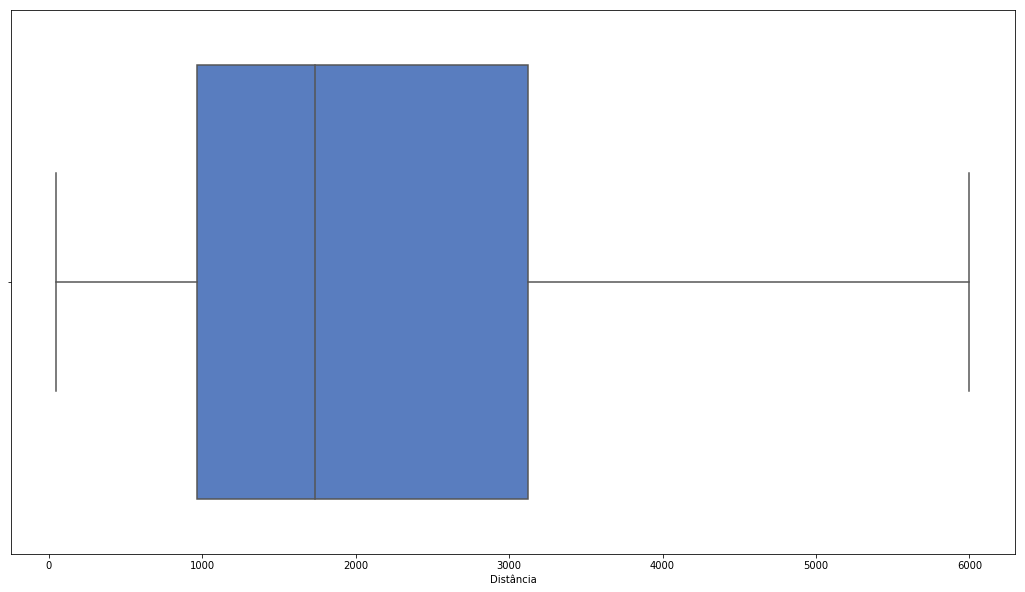

In [13]:
ax = sns.boxplot(x="DISTANCE", data=flows, palette="muted", showfliers = False)
ax.set_xlabel("Distância")
ax.figure.set_size_inches(18,10)
plt.show()


Apesar de termos considerado 6km, a maioria dessas viagens tem até 3km

In [14]:
flows = pd.read_csv("../src/flows.csv", encoding='latin-1')
lines = []
viagens = []

flows = flows.set_index('index')

flows = flows.join(data17, lsuffix='_left', rsuffix='_right')

distri = flows[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distri.columns = ['NOME_O', 'FE_VIA_CARRO']
distri = distri.set_index('NOME_O')
distri['FE_VIA_CARRO'] = distri['FE_VIA_CARRO'].astype(int)
distri.columns = ['Viagens']
distri.tail(10)

,Viagens
NOME_O,
Belem,13922
Saude,13940
Tatuape,13964
Ipiranga,14035
Jabaquara,14105
Moema,16351
Mooca,16908
Itaim Bibi,25185
Jardim Helena,28150


In [15]:
bicicleta = data17[data17['MODOPRIN'] == 'bicicleta']
distri_atual = bicicleta[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distri_atual.columns = ['NOME_O', 'FE_VIA_BICI']
distri_atual = distri_atual.set_index('NOME_O')
distri_atual.tail(10)

,FE_VIA_BICI
NOME_O,
Cidade Lider,4242.165599
Vila Mariana,4316.503722
Moema,4765.634372
Iguatemi,6566.596866
Vila Guilherme,7183.722283
Vila Maria,7303.901374
Pinheiros,8214.936483
Jardim Helena,8628.820164
Ipiranga,10385.901690


In [16]:
total = distri.join(distri_atual)
total.tail(10)

,Viagens,FE_VIA_BICI
NOME_O,,
Belem,13922,1006.951883
Saude,13940,4052.589286
Tatuape,13964,1312.786980
Ipiranga,14035,10385.901690
Jabaquara,14105,283.990582
Moema,16351,4765.634372
Mooca,16908,2913.315667
Itaim Bibi,25185,11245.446740
Jardim Helena,28150,8628.820164


In [17]:
total['POR'] = total['FE_VIA_BICI'] / (total['Viagens'] + total['FE_VIA_BICI']) * 100
total.tail(10)

,Viagens,FE_VIA_BICI,POR
NOME_O,,,
Belem,13922,1006.951883,6.744960
Saude,13940,4052.589286,22.523658
Tatuape,13964,1312.786980,8.593345
Ipiranga,14035,10385.901690,42.528740
Jabaquara,14105,283.990582,1.973666
Moema,16351,4765.634372,22.568153
Mooca,16908,2913.315667,14.697892
Itaim Bibi,25185,11245.446740,30.868265
Jardim Helena,28150,8628.820164,23.461384


In [18]:
flows['H_SAIDA'].head()

index
826     23.0
1181    22.0
1444     2.0
1676    16.0
1720    16.0
Name: H_SAIDA, dtype: float64

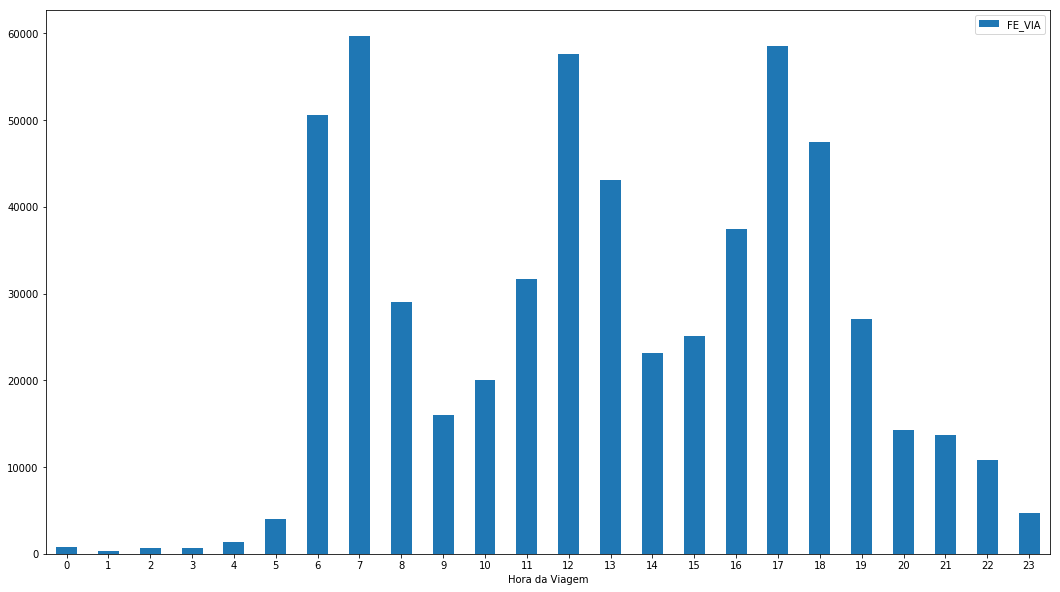

In [19]:


hsaida = flows[['H_SAIDA', 'FE_VIA']].groupby(['H_SAIDA']).sum().sort_values(by=['H_SAIDA']).reset_index()
hsaida.columns = ['H_SAIDA', 'FE_VIA']

hsaida['H_SAIDA'] = hsaida['H_SAIDA'].astype(int)

ax = hsaida.plot.bar(x='H_SAIDA', y='FE_VIA', rot=0)
ax.figure.set_size_inches(18,10)

ax.set_xlabel("Hora da Viagem")
plt.show()